In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
import meshparty
from meshparty import trimesh_vtk, trimesh_io 
import pygsheets
import ast
from collections import Counter
from sklearn.cluster import KMeans
import time
import pickle

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
vol_em = cv('precomputed://gs://zheng_mouse_hippocampus_production/v2/img_aligned_sharded_18nm',parallel=True, use_https=True)
client = CAVEclient('zheng_ca3')

isotropy = [5,5,2]


In [14]:
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import DBSCAN


def cluster_center(points):
    center = points.mean(axis=0)
    d = np.linalg.norm(points - center, axis=1)
    return [center]    

def get_mesh_in_bbox(vertices, faces, bbox):
    x_min, x_max, y_min, y_max, z_min, z_max = bbox
    mask = ((vertices[:, 0] >= x_min) & (vertices[:, 0] <= x_max) &
            (vertices[:, 1] >= y_min) & (vertices[:, 1] <= y_max) &
            (vertices[:, 2] >= z_min) & (vertices[:, 2] <= z_max))
    vertices_in_bbox = vertices[mask]
    vertex_indices = np.where(mask)[0] 
    
    faces_in_bbox = []
    for face in faces:
        if all(v in vertex_indices for v in face):
            faces_in_bbox.append(face)
    faces_in_bbox = np.array(faces_in_bbox)
    index_mapping = {global_idx: local_idx for local_idx, global_idx in enumerate(vertex_indices)}
    new_faces = np.array([[index_mapping[v] for v in face] for face in faces_in_bbox])
    
    return vertices_in_bbox, new_faces

def cluster_vertices_kmeans(vertices, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(vertices)
    return labels, kmeans.cluster_centers_

def cluster_vertices_dbscan(vertices):
    dbscan = DBSCAN(eps=10, min_samples=30)
    labels = dbscan.fit_predict(points)


def split_mesh(vertices, faces, labels):
    sub_meshes = []
    for cluster_id in np.unique(labels):
        cluster_mask = labels == cluster_id
        cluster_vertices = vertices[cluster_mask]
        cluster_indices = np.where(cluster_mask)[0]

        cluster_faces = []
        for face in faces:
            if all(v in cluster_indices for v in face):
                cluster_faces.append(face)
        cluster_faces = np.array(cluster_faces)
        unique_indices = np.unique(cluster_faces)
        if cluster_faces.size == 0:
            sub_meshes.append((cluster_vertices, np.array([])))
            continue           
        index_mapping = {global_idx: local_idx for local_idx, global_idx in enumerate(cluster_indices)}
        new_faces = np.array([[index_mapping[v] for v in face] for face in cluster_faces])
        #face_normals = mesh.face_normals[np.isin(np.arange(len(mesh.faces)), np.flatnonzero(np.all(np.isin(mesh.faces, unique_indices), axis=1)))]
        
        sub_meshes.append((cluster_vertices, new_faces))
    return sub_meshes


def get_foreground_within_convhull(vertices, bw, bbx):
    foreground_coords = np.array(np.nonzero(bw)).T  + [bbx.minpt.x, bbx.minpt.y, bbx.minpt.z]
    hull = ConvexHull(vertices)
    delaunay = Delaunay(vertices[hull.vertices])
    inside_hull = delaunay.find_simplex(foreground_coords) >= 0
    foreground_inside = np.zeros_like(bw, dtype=np.uint8)
    for voxel, is_inside in zip(foreground_coords, inside_hull):
        if is_inside:
            foreground_inside[tuple(voxel - [bbx.minpt.x, bbx.minpt.y, bbx.minpt.z])] = 1
    return foreground_inside


def select_submesh_nearest_to_syn_center(submesh, syn_center):
    group1 = sub_meshes[0][0]
    group2 = sub_meshes[1][0]
    group3 = sub_meshes[2][0]
    
    d1 = np.min(np.linalg.norm(group1 - syn_center, axis=1))
    d2 = np.min(np.linalg.norm(group2 - syn_center, axis=1))
    d3 = np.min(np.linalg.norm(group3 - syn_center, axis=1))
    
    d = np.array([d1,d2,d3])
    nearest_group_idx = np.argmin(d)
    
    return nearest_group_idx

def get_bbox(bw):
    coords = np.argwhere(bw)
    xmin, ymin, zmin = coords.min(axis=0)
    xmax, ymax, zmax = coords.max(axis=0)
    return [xmin, xmax, ymin, ymax, zmin, zmax]    


peacock = (0,0.58,0.8)
coral = (0.95,0.2,0.2)
pistachio = (0.7,0.9,0.6)
purple = (0.7,0.35,0.7)
orange = (0.95,0.7,0.1)

In [109]:
# load MF-PyC ground truth table 
gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('all_pyramidal_cells')
worksheet = sheet.worksheet('title','MF-pyr')
mfpc_df = worksheet.get_as_df(start='A4')

In [3]:
# get latest PC roots

nuclei_coord_in_vol = mfpc_df[['x','y','z']].to_numpy()
latest_roots_PC = []
print('Getting latest roots for PC...')  
cell_ids_scatter = vol.scattered_points(nuclei_coord_in_vol)
for i in range(0, len(nuclei_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(nuclei_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        if client.chunkedgraph.is_latest_roots(cell_ID[0]):
            latest_roots_PC.append(cell_ID[0])
        else:
            latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))
latest_roots_PC_str = [str(num) for num in latest_roots_PC]


Getting latest roots for PC...


Downloading: 100%|████████████████████████████████████████████████████████████████| 646/646 [00:06<00:00, 102.43it/s]


0
100
200
300
400
500
600


In [9]:
# get latest presynaptic MF roots

latest_roots_mf_group = []

stime = time.time()
for i in range(0, len(latest_roots_PC)):
    if type(mfpc_df['GT_MF'][i]) == int:
        pre_mfs_old = [mfpc_df['GT_MF'][i]]
    else:
        pre_mfs_old = [item.strip() for item in mfpc_df['GT_MF'][i].split(',')]
    
    pre_mfs = []    
    if pre_mfs_old[0] == '' and len(pre_mfs_old) == 1:
        pre_mfs.append(None)
    else:
        for j in range(0, len(pre_mfs_old)):
            if int(pre_mfs_old[j]) > 100000000000000000:
                try:
                    this_latest_root = client.chunkedgraph.suggest_latest_roots(pre_mfs_old[j])
                    pre_mfs.append(this_latest_root)
                except:
                    #pre_mfs.append(None)
                    print('failed to return latest root')
    latest_roots_mf_group.append(pre_mfs)
    print(i , ':' , len(pre_mfs))
etime = time.time()
print('Done')
print(etime-stime)


0 : 122
1 : 78
2 : 48
3 : 206
4 : 12
5 : 16
6 : 33
7 : 68
8 : 46
9 : 54
10 : 63
11 : 3
12 : 1
13 : 1
14 : 86
15 : 33
16 : 37
17 : 79
18 : 62
19 : 42
20 : 25
21 : 224
22 : 65
23 : 61
24 : 34
25 : 41
26 : 63
27 : 88
28 : 1
29 : 35
30 : 1
31 : 58
32 : 46
33 : 69
34 : 42
35 : 71
36 : 45
37 : 37
38 : 103
39 : 112
40 : 78
41 : 47
42 : 148
43 : 97
44 : 4
45 : 68
46 : 1
47 : 4
48 : 49
49 : 1
50 : 40
51 : 60
52 : 1
53 : 3
54 : 70
55 : 157
56 : 24
57 : 1
58 : 55
59 : 52
60 : 3
61 : 71
62 : 63
63 : 37
64 : 1
65 : 130
66 : 56
67 : 257
68 : 1
69 : 66
70 : 56
71 : 6
72 : 5
73 : 88
74 : 58
75 : 53
76 : 20
77 : 111
78 : 1
79 : 38
80 : 60
81 : 60
82 : 1
83 : 53
failed to return latest root
84 : 77
85 : 45
86 : 60
87 : 52
88 : 1
89 : 50
90 : 40
91 : 2
92 : 38
93 : 49
94 : 54
95 : 52
96 : 1
failed to return latest root
97 : 26
98 : 63
99 : 73
100 : 1
101 : 57
102 : 1
103 : 59
104 : 56
105 : 69
106 : 1
107 : 1
108 : 47
109 : 94
110 : 1
111 : 28
112 : 44
113 : 43
114 : 3
115 : 38
116 : 5
117 : 69
118 : 104

In [111]:
# remove None

idx_none = [i for i, val in enumerate(latest_roots_mf_group) if val is None or len(val) == 0]
latest_roots_PC = [a for i, a in enumerate(latest_roots_PC) if i not in idx_none]
latest_roots_mf_group = [a for i, a in enumerate(latest_roots_mf_group) if i not in idx_none]

In [206]:
latest_mf = latest_roots_mf_group[0][8]
latest_root_pc = latest_roots_PC[0]
from scipy.spatial import distance
import imageio

mf_pyr_syn_thresh = 4
wsx = 550       # [voxel]
wsz = 220
wsx = 330
wsz = 132
dsyn_outlier_thresh = 10



syn = client.materialize.synapse_query(pre_ids=latest_mf, post_ids=latest_root_pc, bounding_box=None, bounding_box_column='post_pt_position', 
                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                        split_positions=False, desired_resolution=[18,18,45], materialization_version=154, 
                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 

post_freq = syn['post_pt_root_id'].value_counts()
unique_post_ids = post_freq[post_freq > mf_pyr_syn_thresh].index.tolist()

if len(unique_post_ids) > 0:
    for j in range(0, 1):
    #for j in range(0, len(unique_post_ids)):
        center_pos = syn.loc[syn['post_pt_root_id'] == unique_post_ids[j], ['ctr_pt_position']].values
        syn_coords = np.array([arr[0] for arr in center_pos])
        this_syn_center = cluster_center(syn_coords)[0]   

        #if len(syn_coords) > 24:
            #wsx += 80
            #wsz += 32

        # count number of syn too far away from the center of all syn 
        # if there are such syn, then this neuron makes more than one bouton on target cell
        syn_cluster_center_microns = this_syn_center * np.array([18,18,45]) / 1000
        syn_coords_microns = syn_coords * np.array([18,18,45]) / 1000
        n_outlier = 0
        for k in range(0, len(syn_coords_microns)):
            dist = distance.euclidean(syn_coords_microns[k], syn_cluster_center_microns)
            if dist > dsyn_outlier_thresh:
                n_outlier += 1

        if n_outlier > 2:
            print('nn')
#            return ['double_bouton_candidate',latest_mf, unique_post_ids[j], this_syn_center ]

        else:
            print(j)
            bbx = vol.bounds
            bbx.minpt.x = max(bbx.minpt.x, this_syn_center[0] - wsx)
            bbx.maxpt.x = min(bbx.maxpt.x, this_syn_center[0] + wsx)
            bbx.minpt.y = max(bbx.minpt.y, this_syn_center[1] - wsx)
            bbx.maxpt.y = min(bbx.maxpt.y, this_syn_center[1] + wsx)
            bbx.minpt.z = max(bbx.minpt.z, this_syn_center[2] - wsz)
            bbx.maxpt.z = min(bbx.maxpt.z, this_syn_center[2] + wsz)    
            bbox_nm = np.array([bbx.minpt.x, bbx.maxpt.x, bbx.minpt.y, bbx.maxpt.y, bbx.minpt.z, bbx.maxpt.z]) * np.array([18,18,18,18,45,45])
            syn_center_bbox_vx = this_syn_center-[bbx.minpt.x, bbx.minpt.y, bbx.minpt.z]

            mesh_dir = '../mesh_data/'
            mm = trimesh_io.MeshMeta(cv_path='graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3',
                                disk_cache_path=mesh_dir, cache_size=20)
            mesh = mm.mesh(seg_id = latest_mf, remove_duplicate_vertices=True)

            vertices_bbox, faces_bbox = get_mesh_in_bbox(mesh.vertices, mesh.faces, bbox_nm)
            labels, cluster_centers = cluster_vertices_kmeans(vertices_bbox, n_clusters=3)
            sub_meshes = split_mesh(vertices_bbox, faces_bbox, labels)    

            freq = Counter(labels)
            freq_arr = np.array([freq.get(0), freq.get(1),  freq.get(2)])
            bouton_idx = np.argmax(freq_arr)
            nonbouton_idx = list(set([0,1,2]) - set(np.array([bouton_idx])))
            group1 = sub_meshes[bouton_idx][0]
            group2 = sub_meshes[nonbouton_idx[0]][0]
            group3 = sub_meshes[nonbouton_idx[1]][0]

            image = vol.download(bbox=bbx, label=latest_mf)
            img_size = image.shape
            bw = image.reshape(img_size[0], img_size[1], img_size[2])
            vertices = np.round(sub_meshes[bouton_idx][0] / np.array([18,18,45]), decimals=3)
            vertices = vertices[::4]
            seg_bouton = get_foreground_within_convhull(vertices, bw, bbx)
            bouton_vol = np.round(np.sum(seg_bouton) * 0.018 * 0.018 * 0.045, decimals=4)
            
            # measure postsynaptic spine volume
            bouton_bbox = get_bbox(seg_bouton)
            image_seg_original = vol.download(bbox=bbx, label=latest_mf)
            image_seg_original = image_seg_original.reshape(img_size[0], img_size[1], img_size[2])
            image_seg = np.array(image_seg_original[bouton_bbox[0]:bouton_bbox[1],bouton_bbox[2]:bouton_bbox[3],bouton_bbox[4]:bouton_bbox[5]])
            image_seg = image_seg.astype("uint8")
            
            image_em_original = vol_em.download(bbox=bbx)
            image_em_original = image_em_original.reshape(img_size[0], img_size[1], img_size[2])
            image_em = image_em_original[bouton_bbox[0]:bouton_bbox[1],bouton_bbox[2]:bouton_bbox[3],bouton_bbox[4]:bouton_bbox[5]]

            test_slice_seg = image_seg[:,:,(bouton_bbox[5]-bouton_bbox[4])//2]
            test_slice_em = image_em[:,:,(bouton_bbox[5]-bouton_bbox[4])//2]
            
            scale = 7
            new_w = int(test_slice_em.shape[1] * scale)
            new_h = int(test_slice_em.shape[0] * scale)
            resized_img = cv2.resize(test_slice_em, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
            resized_img2 = cv2.resize(test_slice_seg, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

            imageio.imwrite('./result/vesicle_seg/test/test_slice_em.png', resized_img)
            imageio.imwrite('./result/vesicle_seg/test/test_slice_seg.png', resized_img2)            
            

0


Decompressing: 100%|███████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 1807.48it/s]


In [136]:
import cv2

scale = 7
new_w = int(test_slice_em.shape[1] * scale)
new_h = int(test_slice_em.shape[0] * scale)
resized_img = cv2.resize(test_slice_em, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
resized_img2 = cv2.resize(test_slice_seg, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

imageio.imwrite('./result/vesicle_seg/test/test_slice_em.png', resized_img)
imageio.imwrite('./result/vesicle_seg/test/test_slice_gt.png', resized_img2)

In [10]:
import random

def select_boutons_diverse_size(lst, num_per_bin, nbins, nsamples):
    bin_edges = np.linspace(0, max(lst), nbins + 1)
    bin_indices = {i: [] for i in range(nbins)}
    for i, val in enumerate(lst):
        bin_idx = np.digitize(val, bin_edges) -1
        bin_idx = min(bin_idx, nbins - 1)
        bin_indices[bin_idx].append(i)
        
    selected_indices = []
    available_indices = set(range(len(lst)))
    
    for bin_idx, indices in bin_indices.items():
        if len(indices) >= num_per_bin:
            chosen_indices = random.sample(indices, num_per_bin)
        else:
            chosen_indices = indices
        selected_indices.extend(chosen_indices)
        available_indices -= set(chosen_indices)
    
    if nsamples - len(selected_indices) > 0:
        selected_indices.extend(random.sample(list(available_indices), nsamples - len(selected_indices)))
    
    return sorted(selected_indices)



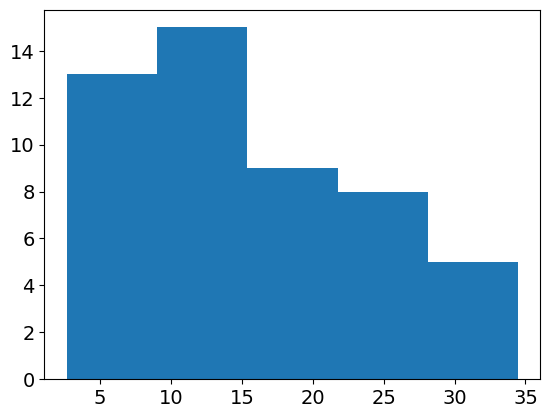

In [11]:
with open("./variables/mf_pyc_gt_bouton_samples.pkl", 'rb') as f:
    loaded_variable = pickle.load(f)
bouton_info = pd.DataFrame(loaded_variable, columns=['pre_mf_id', 'post_pyc_id', 'syn_cluster_center','numsyn','bouton_vol_um3', 'bbox'])
bouton_info = bouton_info[bouton_info['pre_mf_id'] != 'double_bouton_candidate']
bouton_info.reset_index(drop=True, inplace=True)
idx_truncated = [i for i, a in enumerate(bouton_info['syn_cluster_center'].values) if 150 > a[-1] or 2090 < a[-1]]
bouton_info = bouton_info.drop(idx_truncated, axis=0)
bouton_info.reset_index(drop=True, inplace=True)

bouton_size = bouton_info['bouton_vol_um3'].values
random.seed(2)
selected_indices = select_boutons_diverse_size(bouton_size, 6, 5, 50)
selected_sizes = [bouton_size[i] for i in selected_indices]
plt.hist(selected_sizes,5)
bouton_info_selected = bouton_info.iloc[selected_indices]

In [ ]:
# save EM and Seg mask images of selected boutons for vesicle segmentation

from scipy.spatial import distance
import imageio
import cv2

def get_em_and_seg_vol(latest_mf, latest_root_PC, bbx, vol, vol_em):
    image_seg = vol.download(bbox=bbx, label=latest_mf)
    img_size = image_seg.shape
    image_seg = np.array(image_seg.reshape(img_size[0], img_size[1], img_size[2])).astype('uint8')
    image_em = vol_em.download(bbox=bbx)
    image_em = image_em.reshape(img_size[0], img_size[1], img_size[2])
    return [image_em, image_seg]
    
scale = 7
stime = time.time()
bouton_info = bouton_info_selected

for i in range(0,len(bouton_info)):
#for i in range(0, 1):
    image_em, image_seg = get_em_and_seg_vol(bouton_info['pre_mf_id'].iloc[i], bouton_info['post_pyc_id'].iloc[i] ,bouton_info['bbox'].iloc[i], vol, vol_em)
    img_size = image_em.shape
    
#    for j in range(0, 5):
    for j in range(0, img_size[2]):
        em_slice = image_em[:,:,j]
        seg_slice = image_seg[:,:,j]
        new_w = int(em_slice.shape[1] * scale)
        new_h = int(em_slice.shape[0] * scale)
        em_resized = cv2.resize(em_slice, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        seg_resized = cv2.resize(seg_slice, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        imageio.imwrite('./fig/em_and_mask_for_vesicle/em_'+str(i)+'_'+str(j)+'_'+str(bouton_info['pre_mf_id'].iloc[i])+'_'+str(bouton_info['post_pyc_id'].iloc[i])+'.png', em_resized)
        imageio.imwrite('./fig/em_and_mask_for_vesicle/mask_'+str(i)+'_'+str(j)+'_'+str(bouton_info['pre_mf_id'].iloc[i])+'_'+str(bouton_info['post_pyc_id'].iloc[i])+'.png', seg_resized)
    
print('---------------------------------')
print('Done!')
etime = time.time()
print(etime-stime)
print('---------------------------------')

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_96339/398841237.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)


(-0.5, 3205.5, 4087.5, -0.5)

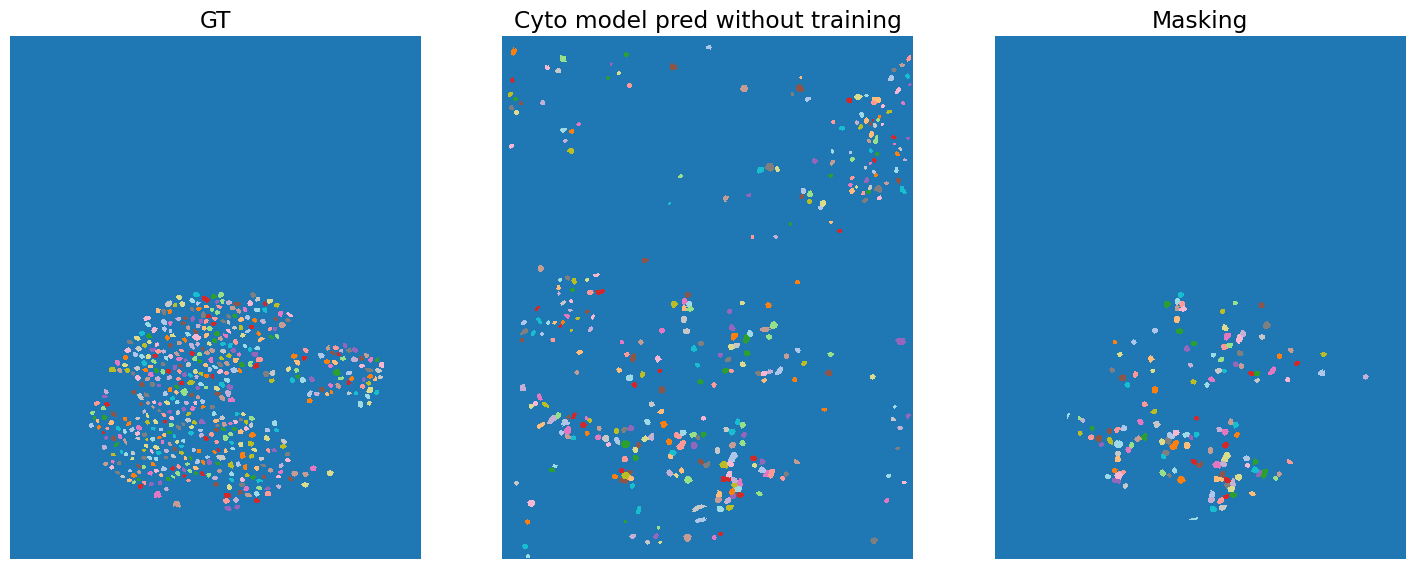

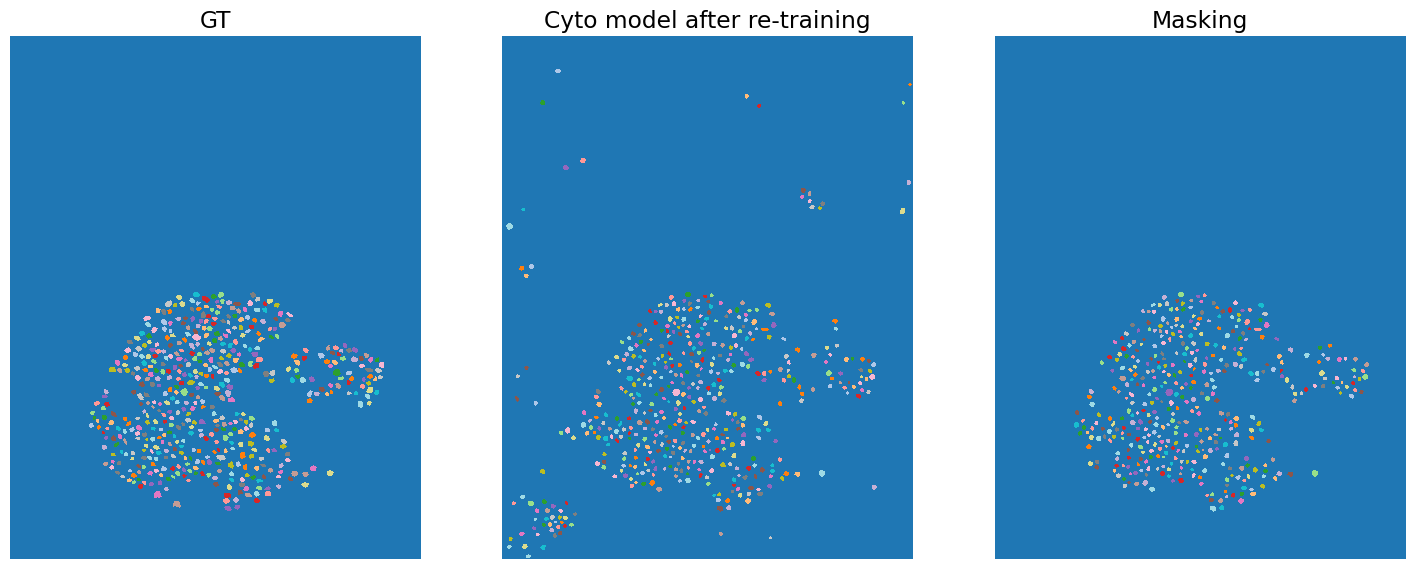

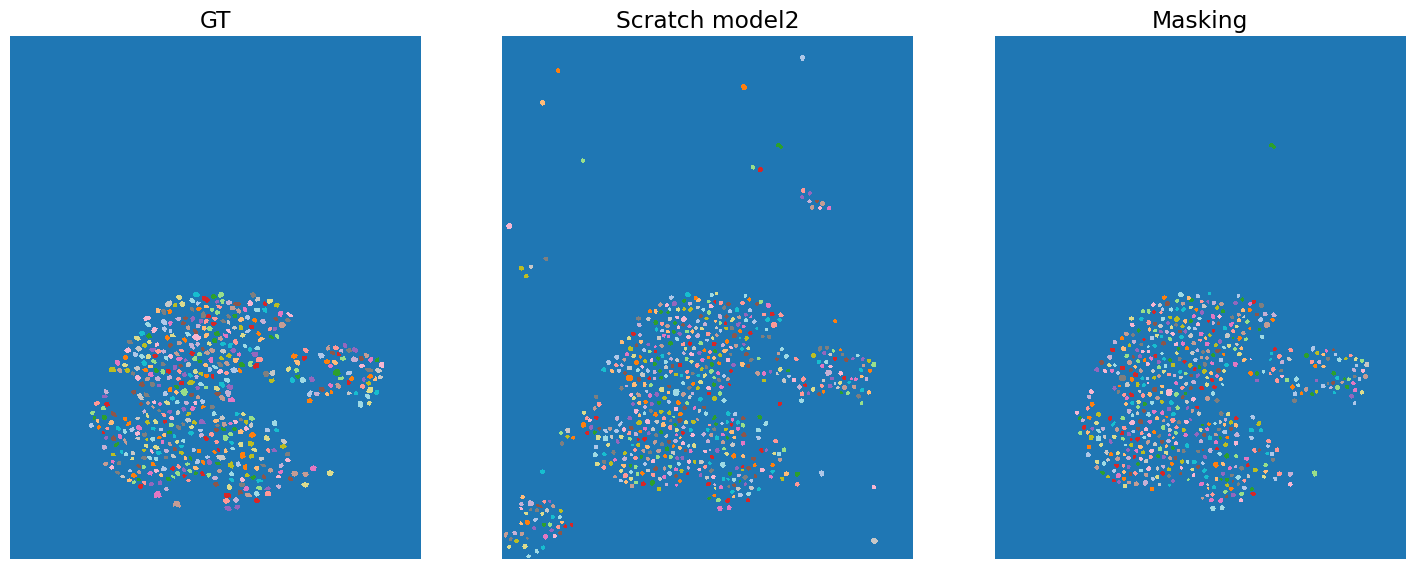

In [22]:
# vesicle segmentation visualization
from PIL import Image
from matplotlib.colors import ListedColormap

labelpath='./result/vesicle_seg/test/gt5_labels.png'
maskpath ='./result/vesicle_seg/test/gt5_neuron_mask.png'
predpath1='./result/vesicle_seg/test/gt5_cyto3_pred.png'
predpath2='./result/vesicle_seg/test/gt5_cyto3_config2_pred.png'
predpath3='./result/vesicle_seg/test/gt5_scratch2_pred.png'

label = np.array(Image.open(labelpath))
mask = np.array(Image.open(maskpath))
pred1 = np.array(Image.open(predpath1))
pred2 = np.array(Image.open(predpath2))
pred3 = np.array(Image.open(predpath3))

pred1m = np.where(mask==1, pred1, 0)
pred2m = np.where(mask==1, pred2, 0)
pred3m = np.where(mask==1, pred3, 0)

custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)

#seg_ids, counts = np.unique(label, return_counts=True)
f, ax = plt.subplots(1,3, figsize=(18,10))
ax = ax.flatten()
plt.rcParams.update({'font.size':14})
ax[0].imshow(label, cmap=custom_color, interpolation='nearest')
ax[0].set_title('GT')
ax[0].axis('off')
ax[1].imshow(pred1, cmap=custom_color, interpolation='nearest')
ax[1].set_title('Cyto model pred without training')
ax[1].axis('off')
ax[2].imshow(pred1m, cmap=custom_color, interpolation='nearest')
ax[2].set_title('Masking')
ax[2].axis('off')

f, ax = plt.subplots(1,3, figsize=(18,10))
ax = ax.flatten()
plt.rcParams.update({'font.size':14})
ax[0].imshow(label, cmap=custom_color, interpolation='nearest')
ax[0].set_title('GT')
ax[0].axis('off')
ax[1].imshow(pred2, cmap=custom_color, interpolation='nearest')
ax[1].set_title('Cyto model after re-training')
ax[1].axis('off')
ax[2].imshow(pred2m, cmap=custom_color, interpolation='nearest')
ax[2].set_title('Masking')
ax[2].axis('off')

f, ax = plt.subplots(1,3, figsize=(18,10))
ax = ax.flatten()
plt.rcParams.update({'font.size':14})
ax[0].imshow(label, cmap=custom_color, interpolation='nearest')
ax[0].set_title('GT')
ax[0].axis('off')
ax[1].imshow(pred3, cmap=custom_color, interpolation='nearest')
ax[1].set_title('Scratch model2')
ax[1].axis('off')
ax[2].imshow(pred3m, cmap=custom_color, interpolation='nearest')
ax[2].set_title('Masking')
ax[2].axis('off')


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_38679/1004154396.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)


Accuracy measurements
n(TP)=509, n(FP)=84, n(FN)=26, Precision=0.858347, Recall=0.951402, F1 score=0.902482


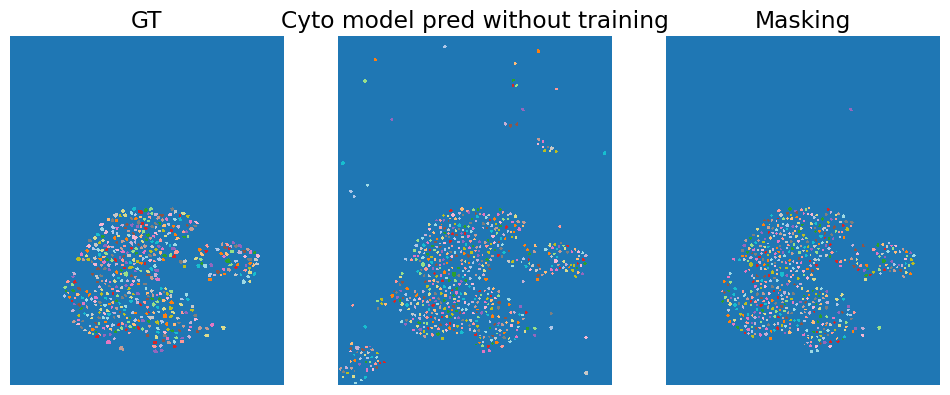

In [217]:
# vesicle segmentation test accuracy for scale =7
from PIL import Image
from matplotlib.colors import ListedColormap

labelpath='./result/vesicle_seg/test/gt5_labels.png'
maskpath ='./result/vesicle_seg/test/test_slice_seg.png'
predpath1='./result/vesicle_seg/test/test_slice_em_cp_masks.png'

label = np.array(Image.open(labelpath))
label = label[::2,::2]
mask = np.array(Image.open(maskpath))
pred1 = np.array(Image.open(predpath1))
pred1m = np.where(mask==1, pred1, 0)
custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)


#seg_ids, counts = np.unique(label, return_counts=True)
f, ax = plt.subplots(1,3, figsize=(12,8))
ax = ax.flatten()
plt.rcParams.update({'font.size':14})
ax[0].imshow(label, cmap=custom_color, interpolation='nearest')
ax[0].set_title('GT')
ax[0].axis('off')
ax[1].imshow(pred1, cmap=custom_color, interpolation='nearest')
ax[1].set_title('Cyto model pred without training')
ax[1].axis('off')
ax[2].imshow(pred1m, cmap=custom_color, interpolation='nearest')
ax[2].set_title('Masking')
ax[2].axis('off')

print('Accuracy measurements')
tp_ids, fp_ids, fn_ids = get_tpfpfn_ids(pred1m, label)
get_accuracy(tp_ids, fp_ids, fn_ids)


In [139]:
# vesicle segmentation accuracy measurement

def get_tpfpfn_ids(pred_image, gt_image):
    pred_ids = np.unique(pred_image)
    gt_ids = np.unique(gt_image)
    pred_ids = pred_ids[pred_ids != 0]
    gt_ids = gt_ids[gt_ids != 0]
    
    tp_ids = []
    fp_ids = []
    fn_ids = []
    
    matched_pred_ids = set()
    matched_gt_ids = set()
    
    for pred_id in pred_ids:
        pred_mask = (pred_image == pred_id)
        overlap = pred_mask & (gt_image > 0)
        if overlap.any():
            gt_id = np.unique(gt_image[overlap])[0]
            matched_pred_ids.add(pred_id)
            matched_gt_ids.add(gt_id)
        else:
            fp_ids.append(pred_id)
    
    for gt_id in gt_ids:
        if gt_id not in matched_gt_ids:
            fn_ids.append(gt_id)
            
    tp_ids = list(matched_gt_ids)
    
    return tp_ids, fp_ids, fn_ids
    

def get_accuracy(tp,fp,fn):
    ntp = len(tp)
    nfp = len(fp)
    nfn = len(fn)
    p = ntp / (ntp + nfp)
    r = ntp / (ntp + nfn)
    f1 = 2*(p*r)/(p+r)
    
    print('n(TP)=%d, n(FP)=%d, n(FN)=%d, Precision=%f, Recall=%f, F1 score=%f'
         % (ntp, nfp, nfn, p, r, f1))

    


In [147]:
print('Accuracy measurements for Cyto model before tuning')
tp_ids, fp_ids, fn_ids = get_tpfpfn_ids(pred1m, label)
get_accuracy(tp_ids, fp_ids, fn_ids)
print('---------------------------------------')
print('Accuracy measurements for Cyto model after tuning')
tp_ids, fp_ids, fn_ids = get_tpfpfn_ids(pred2m, label)
get_accuracy(tp_ids, fp_ids, fn_ids)
print('---------------------------------------')
print('Accuracy measurements for Scratch model')
tp_ids, fp_ids, fn_ids = get_tpfpfn_ids(pred3m, label)
get_accuracy(tp_ids, fp_ids, fn_ids)

Accuracy measurements for Cyto model before tuning
n(TP)=131, n(FP)=8, n(FN)=404, Precision=0.942446, Recall=0.244860, F1 score=0.388724
---------------------------------------
Accuracy measurements for Cyto model after tuning
n(TP)=418, n(FP)=17, n(FN)=117, Precision=0.960920, Recall=0.781308, F1 score=0.861856
---------------------------------------
Accuracy measurements for Scratch model
n(TP)=513, n(FP)=83, n(FN)=22, Precision=0.860738, Recall=0.958879, F1 score=0.907162


(-0.5, 3205.5, 4087.5, -0.5)

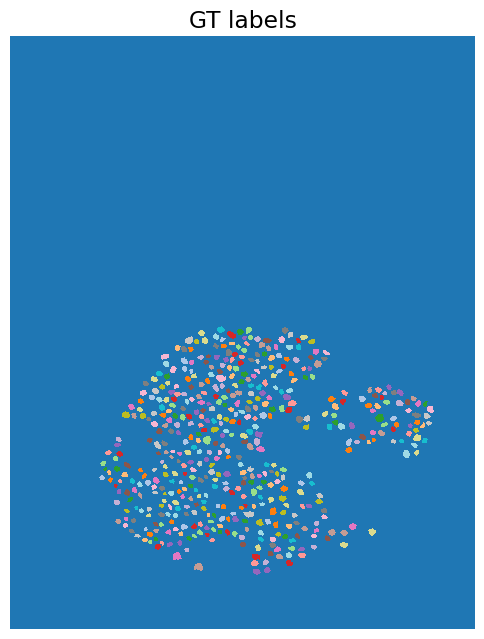

In [6]:
f, ax = plt.subplots(1,1, figsize=(6,8))
plt.rcParams.update({'font.size':14})
plt.imshow(label, cmap=custom_color, interpolation='nearest')
plt.title('GT labels')
plt.axis('off')


In [151]:
seg_ids, counts = np.unique(label, return_counts=True)
print((counts))

[12478036      940     1071      790      636      655      944      610
      608      852     1281     1417     1068      714     1008      835
      922      819      791      720      698      767      925      538
     1308      903      677      681     1372      778     1043     1048
      820      929      850     1142      966     1109      917      766
      854     1140     1004     1105     1222     1056      822     1385
     1324     1004     1350     1138     1044     1132     1442      906
     1539     1058     1127      772     1106      767     1188      906
     1199      875      729      813      864     1006     1135      682
     1034     1059      740      660      748      535      772      721
      554      745      415     1290     1157      894      827     1465
      898      919      960      640     1180     1107     1046      912
     1026      782      834      787      815      793     1092      902
      812      710      863     1124      997      

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_38679/2808464228.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)


(-0.5, 3471.5, 2295.5, -0.5)

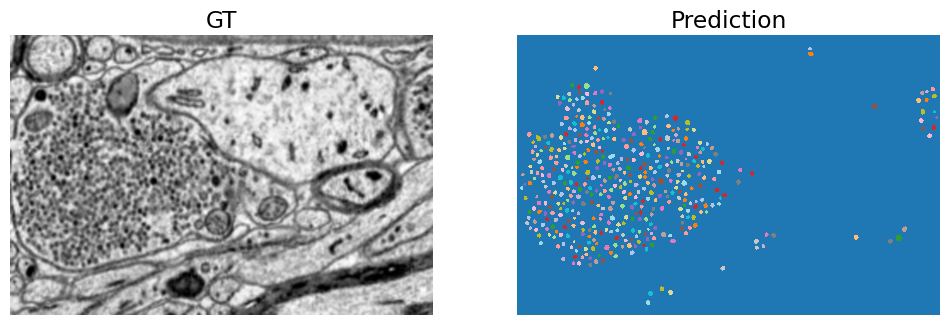

In [192]:
# vesicle segmentation visualization
from PIL import Image
from matplotlib.colors import ListedColormap

ii=52
empath='./result/vesicle_seg/deploy/em_0_'+str(ii)+'_648518346445372622_648518346450997921.png'
maskpath ='./result/vesicle_seg/deploy/em_0_'+str(ii)+'_648518346445372622_648518346450997921.png'
predpath1='./result/vesicle_seg/deploy/em_0_'+str(ii)+'_648518346445372622_648518346450997921_cp_masks.png'

em1 = np.array(Image.open(empath))
mask = np.array(Image.open(maskpath))
pred1 = np.array(Image.open(predpath1))

custom_color = ListedColormap(plt.cm.get_cmap('tab20').colors*25)

#seg_ids, counts = np.unique(label, return_counts=True)
f, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
plt.rcParams.update({'font.size':14})
ax[0].imshow(em1, cmap='gray')
ax[0].set_title('GT')
ax[0].axis('off')
ax[1].imshow(pred1, cmap=custom_color, interpolation='nearest')
ax[1].set_title('Prediction')
ax[1].axis('off')






In [ ]:
# selected bouton size vs number of vesicles

import glob

#print(bouton_info_selected)

vesicle_counts = []
bouton_sizes = []

for i in range(0,len(bouton_info_selected)):
#for i in range(1, 2):
    mask_files = sorted(glob.glob('./fig/em_and_mask_for_vesicle/mask_' +str(i) + '_*.png'))
    pred_files = sorted(glob.glob('./result/vesicle_seg/prediction/em_'+str(i)+'_*.png'))
    if len(pred_files) > 0:
    
        mask_number = []
        for j in range(0, len(mask_files)):
            temp = mask_files[j].split('_')
            mask_number.append(temp[-3]) 

        vesicle_count = 0
        for j in range(0, len(pred_files)):
            temp = pred_files[j].split('_')
            pred_number = temp[-5]
            index = mask_number.index(pred_number)
            pred = np.array(Image.open(pred_files[j]))
            mask = np.array(Image.open(mask_files[index]))
            pred_masked = np.where(mask==1, pred, 0)

            pred_ids, counts = np.unique(pred_masked, return_counts=True)
            valid_ids = pred_ids[(counts >= 100) & (pred_ids != 0)] 
            vesicle_count += len(valid_ids)
            #f, ax = plt.subplots(1,1, figsize=(12,6))
            #plt.imshow(pred_masked, cmap=custom_color, interpolation='nearest')
        vesicle_counts.append(vesicle_count)
        bouton_sizes.append(bouton_info_selected['bouton_vol_um3'].values[i])
    print(i)
print(vesicle_counts)  
print(bouton_sizes)

46


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_96339/395323979.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bouton_sizes,vesicle_counts , s=20, c=peacock)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_96339/395323979.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bouton_sizes,vesicle_counts , s=32, c=peacock)


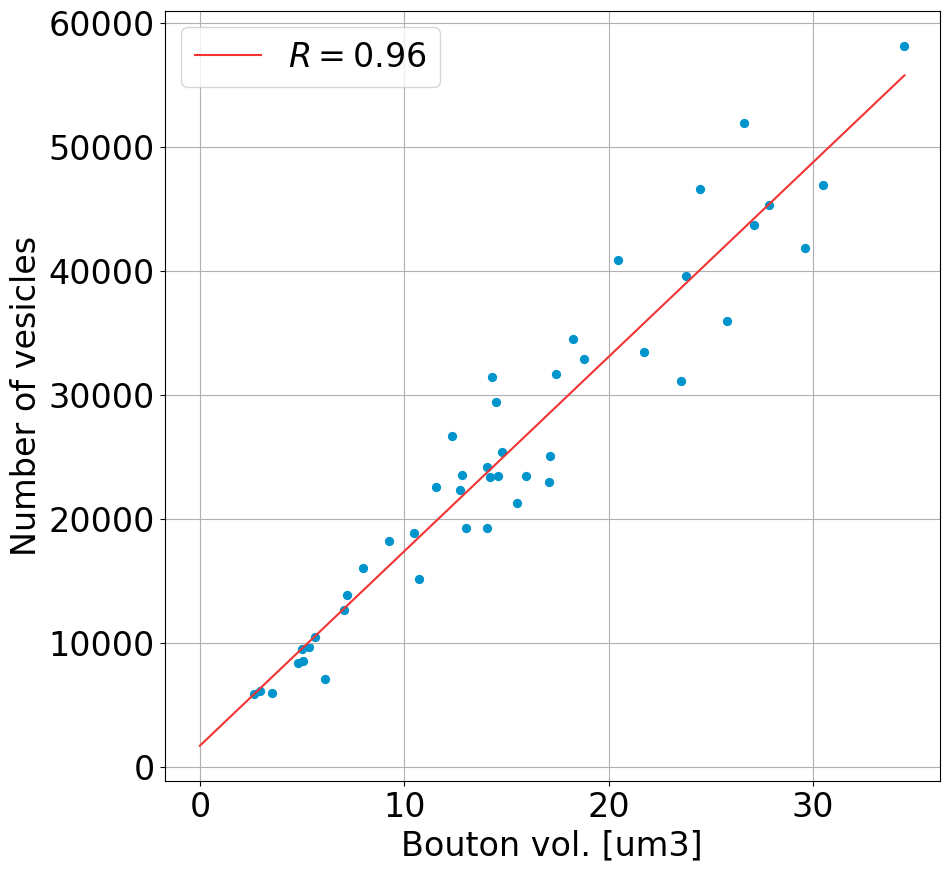

In [25]:
print(len(vesicle_counts))
from scipy.stats import linregress


f, ax = plt.subplots(1,1, figsize=(10,10))
plt.rcParams.update({'font.size': 24})
plt.scatter(bouton_sizes,vesicle_counts , s=20, c=peacock)
plt.xlabel('Bouton vol. [um3]')
plt.ylabel('Number of vesicles')

m,b,r_val,_,_ = linregress(bouton_sizes,vesicle_counts)
xx = np.linspace(0,max(bouton_sizes),100)
y_pred = m*xx +b
#plt.xlim([0,60])
plt.plot(xx, y_pred, color=coral, label=f"$R={r_val:.2f}$")
plt.legend()
plt.grid(True)
plt.scatter(bouton_sizes,vesicle_counts , s=32, c=peacock)


(array([  7.,  37., 101., 129.,  73.,  29.,  12.,   5.,   2.,   3.]),
 array([ 52. ,  95.1, 138.2, 181.3, 224.4, 267.5, 310.6, 353.7, 396.8,
        439.9, 483. ]),
 <BarContainer object of 10 artists>)

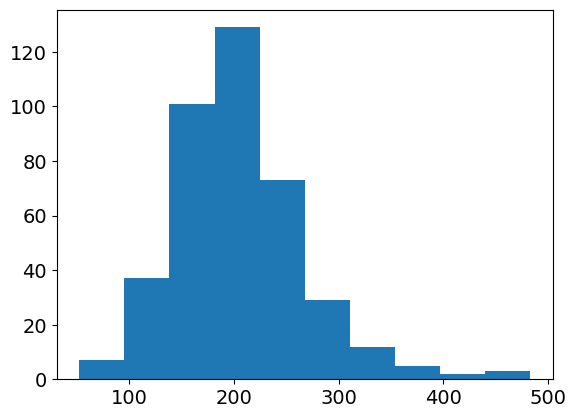

In [255]:
plt.hist(counts_new)